# CIS8005 DATA PROGRAMMING 
# Project: Fraud Detection in Vehicle insurance claim
# Instructor: Andrea Aria
# Team Mario

# 1. Introduction

In [1]:
#libraries imported for processing
import pandas as pd #file reading
import numpy as np #matematical computations
import matplotlib.pyplot as plt #plotting
import seaborn as sns #plotting
import warnings
import scipy.stats as ss #statistical computations
import math #mathematical computations

from itertools import product
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, recall_score, precision_score, plot_confusion_matrix,auc,plot_roc_curve

from imblearn.over_sampling import SMOTE #for over sampling
from category_encoders.ordinal import OrdinalEncoder #label encoder
from category_encoders.one_hot import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
#reading dataset
df = pd.read_csv('fraud_oracle.csv', index_col=False)

# Exploratory Data Analysis

# **Data Dictionary (at first glance)**
Results of printing the unique values from each feature. Things I noticed about each feature.
1. **Month** - object
    * contains 3 letter abbreviations for the months of the year 
    * Are these the months in which the accident occured?
2. **WeekOfMonth** - int64
    * provides the week in the month the accident occured?
3. **DayOfWeek** - object
    * contains days of the week - are these the days of the week the accident occured on?
4. **Make** - object
    * contains a list of 19 car manufacturers
5. **AccidentArea** - object
    * classifies area for accident as "Urban" or "Rural"
6. **DayOfWeekClaimed** - object
    * contains the day of the week the claim was filed
    * also contains '0' - need to check how many of these there are and see about "fixing" - missing data?
7. **MonthClaimed** - object
    * contains 3 letter abbreviations for the months of the year 
    * contains '0' - need to check how many there are and what they mean - missing data?
8. **WeekOfMonthClaimed** - int64
    * contains weeks in the month that the claimed in filed
9. **Sex** - object
    * gender of individual making claim?
    * binary data, convert to 1 or 0
10. **MaritalStatus** - object
    * marital status of individual making claim?
11. **Age** - int64
    * ages of individual making claim?
    * there is at least one individual with age 0 - missing data?
12. **Fault** - object
    * categorization of who was deemed at fault.
    * convert to binary, 1 or 0
13. **PolicyType** - object
    * contains two pieces of info - 
        * the type of insurance on the car - liability, all perils, collision
        * category of the vehicle - sport, sedan, utility
14. **VehicleCategory** - object
    * contains the categorization of the vehicle (see PolicyType)
15. **VehiclePrice** - object
    * contains ranges for the value of the vehicle
    * replace ranges with mean value of range and convert to float
16. **FraudFound_P** - int64
    * indicats whether the claim was fraudulant (1) or not (0)
    * **this is what we want to predict**
17. **PolicyNumber** - int64
    * the masked policy number, appears to be the same as row number minus 1
18. **RepNumber** - int64
    * rep number is  integer from 1 - 16
19. **Deductible** - int64
    * the deductible amount
    * integer values
20. **DriverRating** - int64
    * the scale is 1, 2, 3, 4
    * the name DriverRating implies the data is ordinal, but is it interval as well?
21. **Days_Policy_Accident** - object
    * as a guess, this is the number of days between when the policy was purchased and the accident occured
    * each value is again a range of values
    * change these to be mean of the range and make float
22. **Days_Policy_Claim** - object
    * another guess, this is the number of days that pass between the policy was purchased and the claim was filed
    * each value is a range
    * change these to be the mean of the ranges and make float
23. **PastNumberOfClaims** - object
    * previous number of claims filed by policy holder (or claimant?)
24. **AgeOfVehicle** - object
    * represents age of vehicle at time of the accident?
    * each value is a range of years
    * change these to be the mean of the ranges and make float
25. **AgeOfPolicyHolder** - object
    * each value is a range of ages"
    * change these to be the mean of the ranges and make float
26. **PoliceReportFiled** - object
    * indicates whether a police report was filed for the accident
    * convert to binary
27. **WitnessPresent** - object
    * indicted whether a witness was present
    * conver to binary
28. **AgentType** -  object
    * this classifies an agent who is handling the claim as internal vs external
    * what does this mean? 
    * change to binary
29. **NumberOfSuppliments** - object
    * probably not the number of vitamins taken daily
    * not sure what a suppliment is in insurance
30. **AddressChange_Claim** - object
    * guess, time from claim was filled to when person moved (i.e. filed an address change)
    * replace each interval with mean value of range
31. **NumberOfCars** - object
    * guess, number of cars involved in accident OR number of cars covered under policy
    * replace each interval with mean value of range
32. **Year** - int64
    * guess, year accident occured
33. **BasePolicy** - object
    * type of insurance coverage (see PolicyType)


In [3]:
df.head() #first 5 rows of dataset

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [5]:
#checking for any null values
df.isnull().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

# 2. Columns

In [6]:
#checking foe categorical values in each column
for column in df:
    if column == 'PolicyNumber':
        pass
    else:
        print(column)
        print(sorted(df[column].unique()),"\n")

Month
['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'] 

WeekOfMonth
[1, 2, 3, 4, 5] 

DayOfWeek
['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'] 

Make
['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda', 'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson', 'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW'] 

AccidentArea
['Rural', 'Urban'] 

DayOfWeekClaimed
['0', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'] 

MonthClaimed
['0', 'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'] 

WeekOfMonthClaimed
[1, 2, 3, 4, 5] 

Sex
['Female', 'Male'] 

MaritalStatus
['Divorced', 'Married', 'Single', 'Widow'] 

Age
[0, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 7

## Issue
- DayOfWeekClaimed, MonthClaimed, and Age contains a 0
- PolicyType is a concenation of VehicleCategory and BasePolicy
- PolicyNumber just a row number

In [7]:
# Check DayOfWeekClaimed == 0
df[df['DayOfWeekClaimed']=='0']

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
1516,Jul,2,Monday,Honda,Rural,0,0,1,Male,Single,0,Policy Holder,Sedan - All Perils,Sedan,more than 69000,0,1517,15,400,2,more than 30,none,none,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils


In [8]:
# Check MonthClaimed == 0
df[df['MonthClaimed']=='0']

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
1516,Jul,2,Monday,Honda,Rural,0,0,1,Male,Single,0,Policy Holder,Sedan - All Perils,Sedan,more than 69000,0,1517,15,400,2,more than 30,none,none,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils


In [9]:
# Check Age == 0
print(df[df['Age']==0].shape)
df[df['Age']==0].sample(3)

(320, 33)


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
9528,Jun,2,Monday,Honda,Rural,Monday,Jun,2,Male,Single,0,Policy Holder,Sedan - Liability,Sport,more than 69000,0,9529,13,400,2,more than 30,more than 30,2 to 4,new,16 to 17,No,No,External,none,no change,1 vehicle,1995,Liability
9455,May,2,Sunday,Honda,Urban,Monday,May,2,Male,Single,0,Policy Holder,Sedan - Collision,Sedan,more than 69000,0,9456,12,400,2,more than 30,more than 30,1,new,16 to 17,Yes,No,External,none,no change,1 vehicle,1995,Collision
14967,Jun,4,Sunday,Honda,Rural,Monday,Jun,4,Male,Single,0,Policy Holder,Sedan - Liability,Sport,more than 69000,0,14968,11,400,2,more than 30,more than 30,more than 4,new,16 to 17,No,No,External,none,no change,1 vehicle,1996,Liability


In [10]:
#dropping Policy Number column as it has no impact
df=df.drop(columns='PolicyNumber')

In [11]:
print(df.shape)

(15420, 32)


## Cleansing

In [12]:
# Drop DayOfWeekClaimed & MonthClaimed == 0, since the 0 in the same row and only one row, so we can drop it
df = df[~(df['MonthClaimed']=='0')]

In [13]:
# Analysis row with Age == 0
print(df[df['Age']==0]['AgeOfPolicyHolder'].unique()) #Result = array(['16 to 17'], dtype=object)

# Because the row with Age == 0, only appear in row with AgeOfPolicyHolder == '16 to 17', i will impute with 16.5
df['Age'] =df['Age'].replace({0:16.5})

['16 to 17']


# 3. Further Analysis

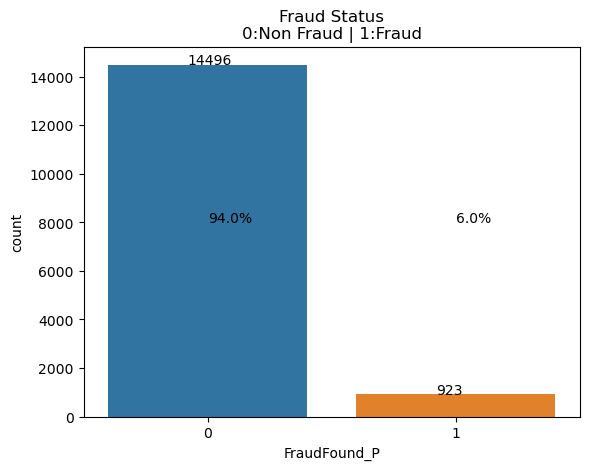

In [14]:
#checking the count of outcome variables
ax = sns.countplot(df['FraudFound_P'],
                   order = df["FraudFound_P"].value_counts().index)

for p, label in zip(ax.patches, df["FraudFound_P"].value_counts().values):
    ax.annotate(label, (p.get_x()+0.320, p.get_height()))
    
ax.set_title('Fraud Status\n0:Non Fraud | 1:Fraud')
ax.text(0, 8000, f'{round(14496/len(df),2)*100}%')
ax.text(1, 8000, f'{round(923/len(df),2)*100}%')
plt.show()

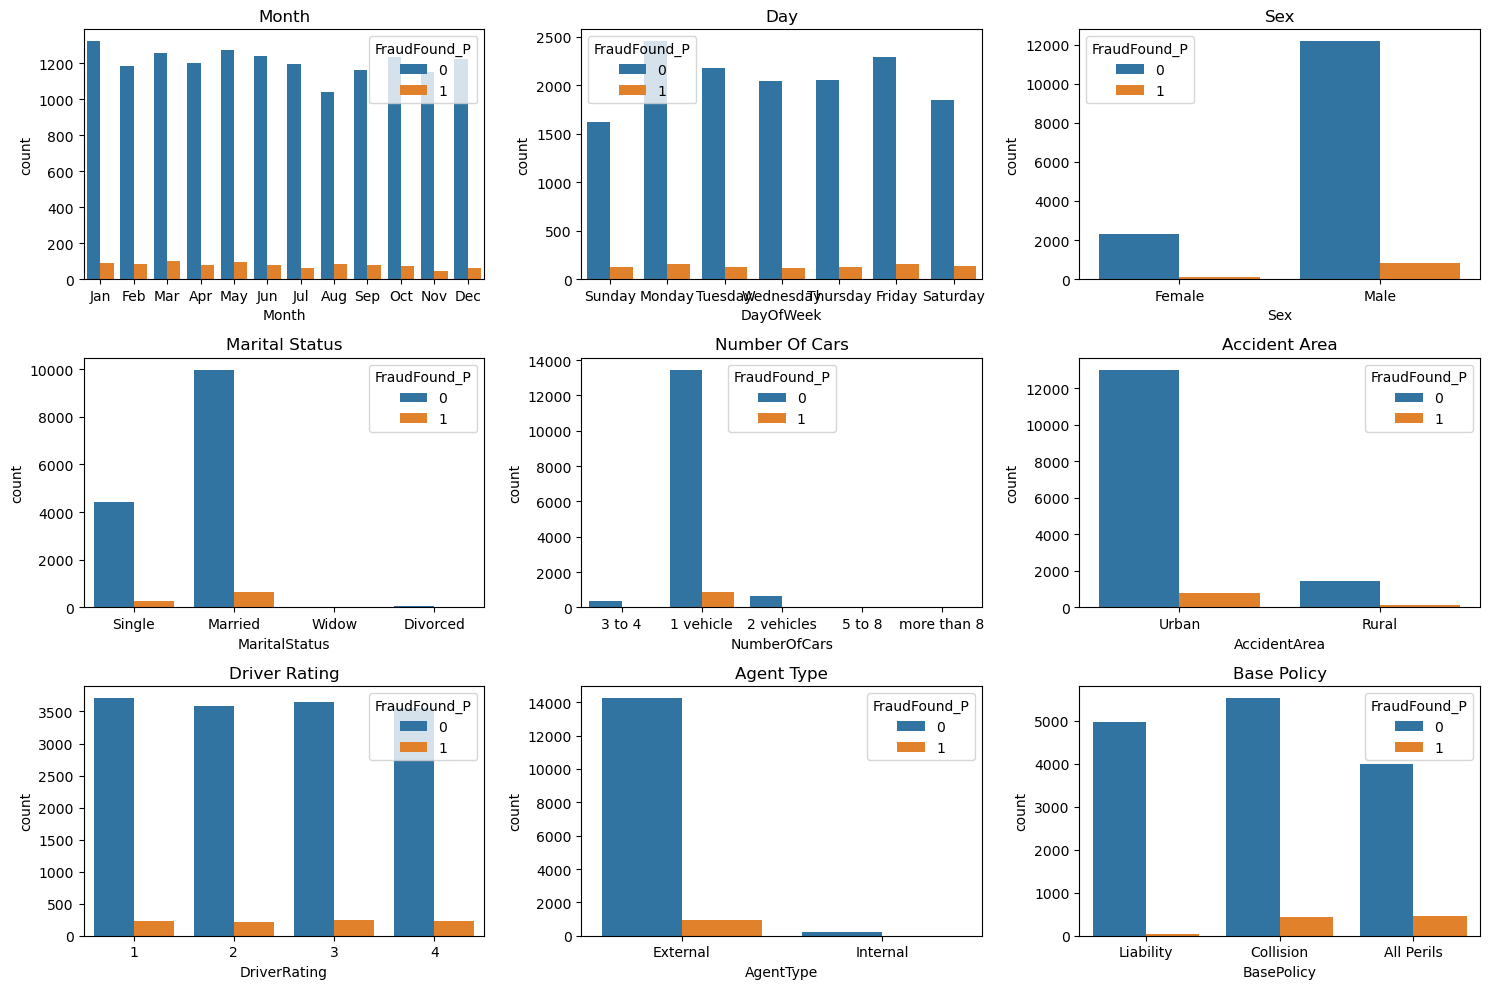

In [15]:
#Univariate analysis with legend as fraud yes or no
fig, ax = plt.subplots(3,3, figsize=(15,10))
sns.countplot(data=df, x='Month', hue='FraudFound_P', order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], ax=ax[0][0])
ax[0][0].set_title('Month')

sns.countplot(data=df, x='DayOfWeek', hue='FraudFound_P', order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], ax=ax[0][1])
ax[0][1].set_title('Day')

sns.countplot(data=df, x='Sex', hue='FraudFound_P', ax=ax[0][2])
ax[0][2].set_title('Sex')

sns.countplot(data=df, x='MaritalStatus', hue='FraudFound_P', ax=ax[1][0])
ax[1][0].set_title('Marital Status')

sns.countplot(data=df, x='NumberOfCars', hue='FraudFound_P', ax=ax[1][1])
ax[1][1].set_title('Number Of Cars')

sns.countplot(data=df, x='AccidentArea', hue='FraudFound_P', ax=ax[1][2])
ax[1][2].set_title('Accident Area')

sns.countplot(data=df, x='DriverRating', hue='FraudFound_P', ax=ax[2][0])
ax[2][0].set_title('Driver Rating')

sns.countplot(data=df, x='AgentType', hue='FraudFound_P', ax=ax[2][1])
ax[2][1].set_title('Agent Type')

sns.countplot(data=df, x='BasePolicy', hue='FraudFound_P', ax=ax[2][2])
ax[2][2].set_title('Base Policy')


plt.tight_layout()

,PolicyType,FraudFound_P,Total Accidents,Percentage by PolicyType,Percentage by Total
0,Sedan - All Perils,411,4086,10.059,2.666
1,Sedan - Collision,384,5584,6.877,2.49
2,Sedan - Liability,36,4987,0.722,0.233
3,Sport - All Perils,0,22,0.0,0.0
4,Sport - Collision,48,348,13.793,0.311
5,Sport - Liability,0,1,0.0,0.0
6,Utility - All Perils,41,340,12.059,0.266
7,Utility - Collision,3,30,10.0,0.019
8,Utility - Liability,0,21,0.0,0.0
9,Column total,923,15419,53.51,5.985


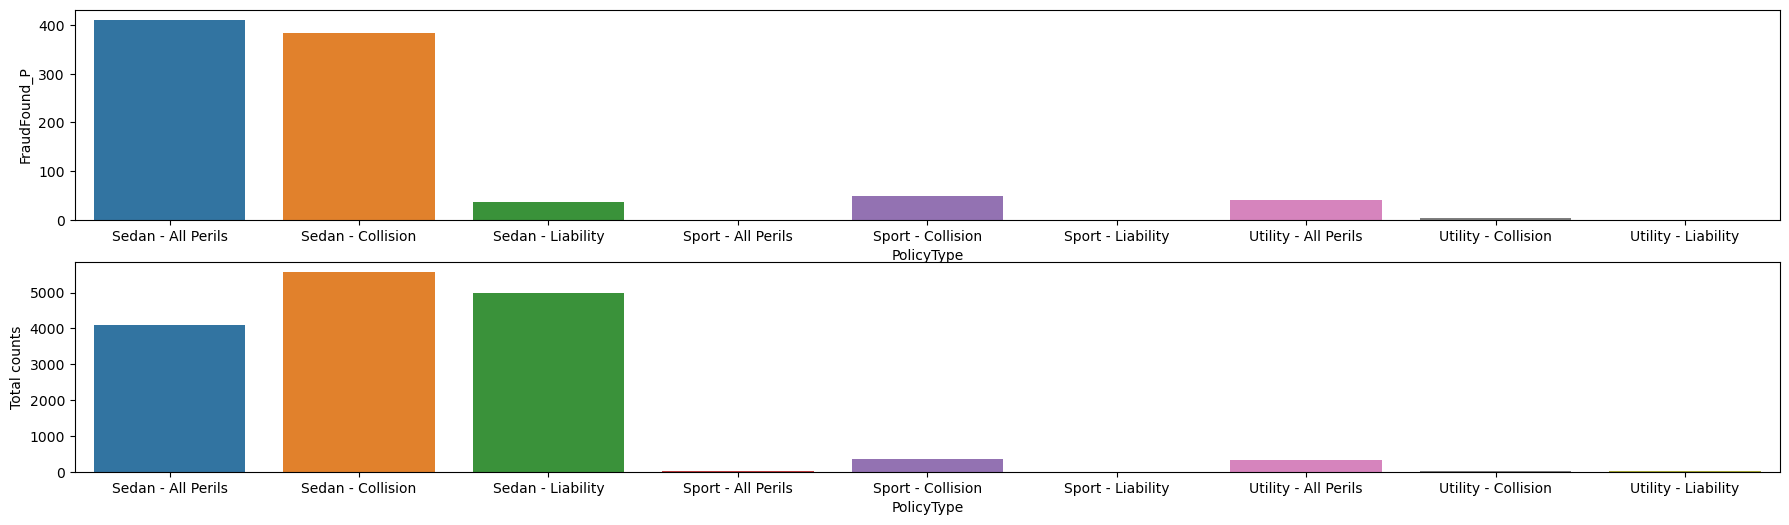

In [16]:
#plotting by FraudFound, looking to see if there are anything obvious that correlates to fraud
gpd_val1=df.groupby('PolicyType').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val2=df.groupby('PolicyType').agg('count').reset_index()

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(22, 6))
sns.barplot(x='PolicyType', y='FraudFound_P', data = gpd_val1, ax=ax1)
sns.barplot(x='PolicyType', y='FraudFound_P', data=gpd_val2, ax=ax2)

ax2.set(ylabel='Total counts')


total_list = pd.concat([gpd_val1, gpd_val2['FraudFound_P'].rename('Total Accidents')],axis=1)
total_list['Percentage by PolicyType']= round((total_list['FraudFound_P']/total_list['Total Accidents'])*100,3)
total_list['Percentage by Total'] = round((total_list['FraudFound_P']/sum(total_list['Total Accidents']))*100,3)

ax2.set(ylabel='Total counts')

data = [['Column total'],
        [sum(total_list['FraudFound_P'])], 
        [sum(total_list['Total Accidents'])], 
        [sum(total_list['Percentage by PolicyType'])], 
        [sum(total_list['Percentage by Total'])]]

nr = pd.DataFrame(data)

nr1 = nr.transpose()
nr1.rename(columns={0:'PolicyType',1:'FraudFound_P',2:'Total Accidents',3:'Percentage by PolicyType',4:'Percentage by Total'}, inplace=True)
pd.concat([total_list,nr1],ignore_index=True)

,VehicleCategory,FraudFound_P,Total Accidents,Percentage by VehicleCategory,Percentage by Total
0,Sedan,795,9670,8.221,5.156
1,Sport,84,5358,1.568,0.545
2,Utility,44,391,11.253,0.285
3,Column total,923,15419,21.042,5.986


,BasePolicy,FraudFound_P,Total Accidents,Percentage by BasePolicy,Percentage by Total
0,All Perils,452,4448,10.162,2.931
1,Collision,435,5962,7.296,2.821
2,Liability,36,5009,0.719,0.233
3,Column total,923,15419,18.177,5.985


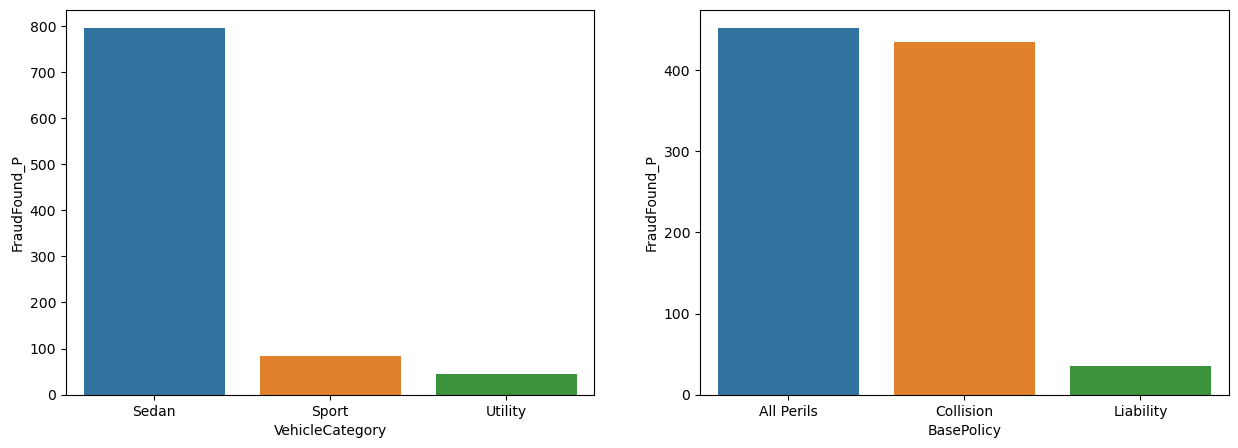

In [17]:
#plotting by FraudFound, looking to see if there are anything obvious that correlates to fraud
#vehicle category and Base policy
gpd_val1=df.groupby('VehicleCategory').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val6=df.groupby('VehicleCategory').agg('count').reset_index()
gpd_val3=df.groupby('BasePolicy').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val7=df.groupby('BasePolicy').agg('count').reset_index()

fig, (ax1, ax3) = plt.subplots(1,2,figsize=(15, 5))
sns.barplot(x='VehicleCategory', y='FraudFound_P', data = gpd_val1, ax=ax1)
#sns.barplot(x='VehicleCategory', y='FraudFound_P', data = gpd_val2, ax=ax2)
sns.barplot(x='BasePolicy', y='FraudFound_P', data = gpd_val3, ax=ax3)
#sns.barplot(x='BasePolicy', y='FraudFound_P', data = gpd_val4, ax=ax4)



total_list1 = pd.concat([gpd_val1, gpd_val6['FraudFound_P'].rename('Total Accidents')],axis=1)
total_list1['Percentage by VehicleCategory']= round((total_list1['FraudFound_P']/total_list1['Total Accidents'])*100,3)
total_list1['Percentage by Total'] = round((total_list1['FraudFound_P']/sum(total_list1['Total Accidents']))*100,3)

total_list2 = pd.concat([gpd_val3, gpd_val7['FraudFound_P'].rename('Total Accidents')],axis=1)
total_list2['Percentage by BasePolicy']= round((total_list2['FraudFound_P']/total_list2['Total Accidents'])*100,3)
total_list2['Percentage by Total'] = round((total_list2['FraudFound_P']/sum(total_list2['Total Accidents']))*100,3)

data1 = [['Column total'],
        [sum(total_list1['FraudFound_P'])], 
        [sum(total_list1['Total Accidents'])], 
        [sum(total_list1['Percentage by VehicleCategory'])], 
        [sum(total_list1['Percentage by Total'])]]

data2 = [['Column total'],
        [sum(total_list2['FraudFound_P'])], 
        [sum(total_list2['Total Accidents'])], 
        [sum(total_list2['Percentage by BasePolicy'])], 
        [sum(total_list2['Percentage by Total'])]]

nr1 = pd.DataFrame(data1)
nr1 = nr1.transpose()
nr1.rename(columns={0:'VehicleCategory',1:'FraudFound_P',2:'Total Accidents',3:'Percentage by VehicleCategory',4:'Percentage by Total'}, inplace=True)
tl1=pd.concat([total_list1,nr1],ignore_index=True)

nr2 = pd.DataFrame(data2)
nr2 = nr2.transpose()
nr2.rename(columns={0:'BasePolicy',1:'FraudFound_P',2:'Total Accidents',3:'Percentage by BasePolicy',4:'Percentage by Total'}, inplace=True)
tl2=pd.concat([total_list2,nr2],ignore_index=True)

# print(tabulate(tl1, headers=tl1.columns))
# print(' ')
# print(tabulate(tl2, headers=tl2.columns))
display(tl1)
display(tl2)

,Make,FraudFound_P,Total Accidents,Percentage by Make,Percentage by Total
0,Accura,59,472,12.5,0.383
1,BMW,1,15,6.667,0.006
2,Chevrolet,94,1681,5.592,0.61
3,Dodge,2,109,1.835,0.013
4,Ferrari,0,2,0.0,0.0
5,Ford,33,450,7.333,0.214
6,Honda,179,2800,6.393,1.161
7,Jaguar,0,6,0.0,0.0
8,Lexus,0,1,0.0,0.0
9,Mazda,123,2354,5.225,0.798


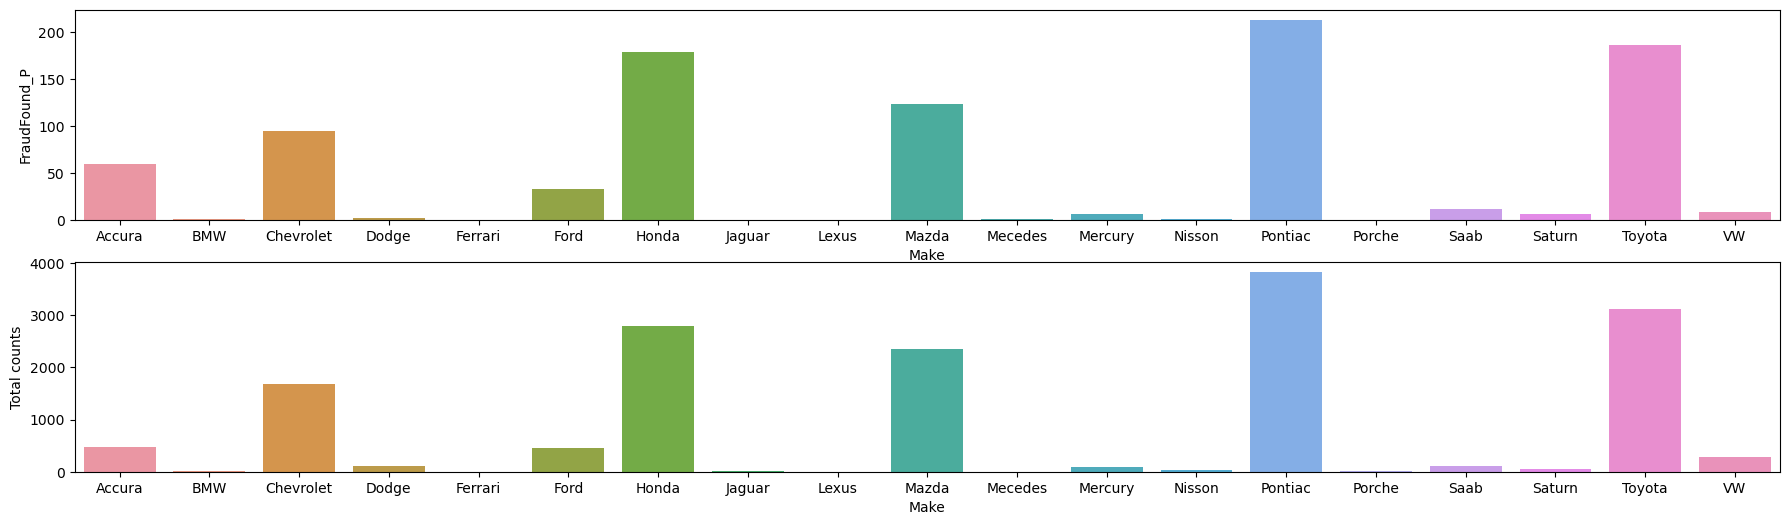

In [18]:
#plotting by FraudFound, looking to see if there are anything obvious that correlates to fraud
#car make
gpd_val1=df.groupby('Make').agg({'FraudFound_P':'sum'}).reset_index()
gpd_val2=df.groupby('Make').agg('count').reset_index()

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(22, 6))
sns.barplot(x='Make', y='FraudFound_P', data = gpd_val1,ax=ax1)
sns.barplot(x='Make', y='FraudFound_P', data = gpd_val2,ax=ax2)

total_list = pd.concat([gpd_val1, gpd_val2['FraudFound_P'].rename('Total Accidents')],axis=1)
total_list['Percentage by Make']= round((total_list['FraudFound_P']/total_list['Total Accidents'])*100,3)
total_list['Percentage by Total'] = round((total_list['FraudFound_P']/sum(total_list['Total Accidents']))*100,3)

ax2.set(ylabel='Total counts')

data = [['Column total'],
        [sum(total_list['FraudFound_P'])], 
        [sum(total_list['Total Accidents'])], 
        [sum(total_list['Percentage by Make'])], 
        [sum(total_list['Percentage by Total'])]]

nr = pd.DataFrame(data)

nr1 = nr.transpose()
nr1.rename(columns={0:'Make',1:'FraudFound_P',2:'Total Accidents',3:'Percentage by Make',4:'Percentage by Total'}, inplace=True)
pd.concat([total_list,nr1],ignore_index=True)

# 4 Correlation

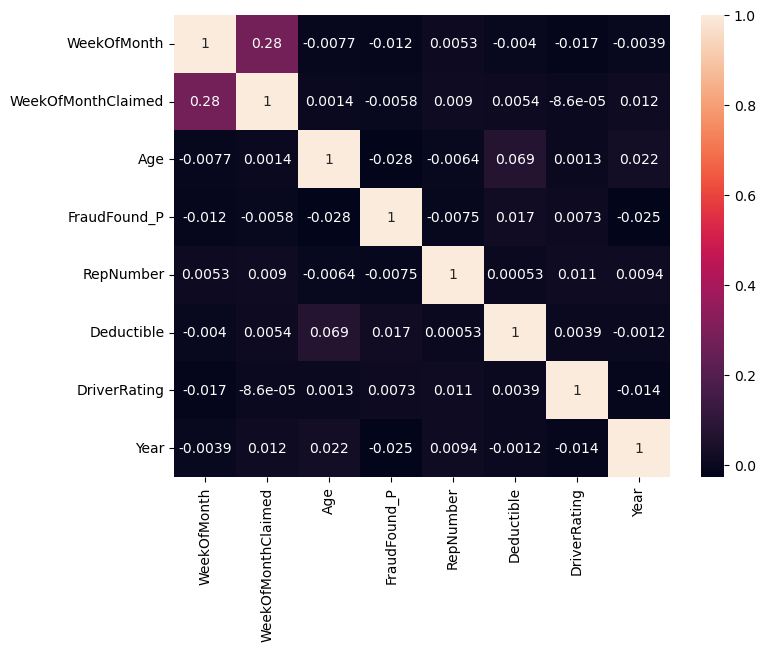

In [19]:
# Correlation Between numerical variables
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True)
plt.show()

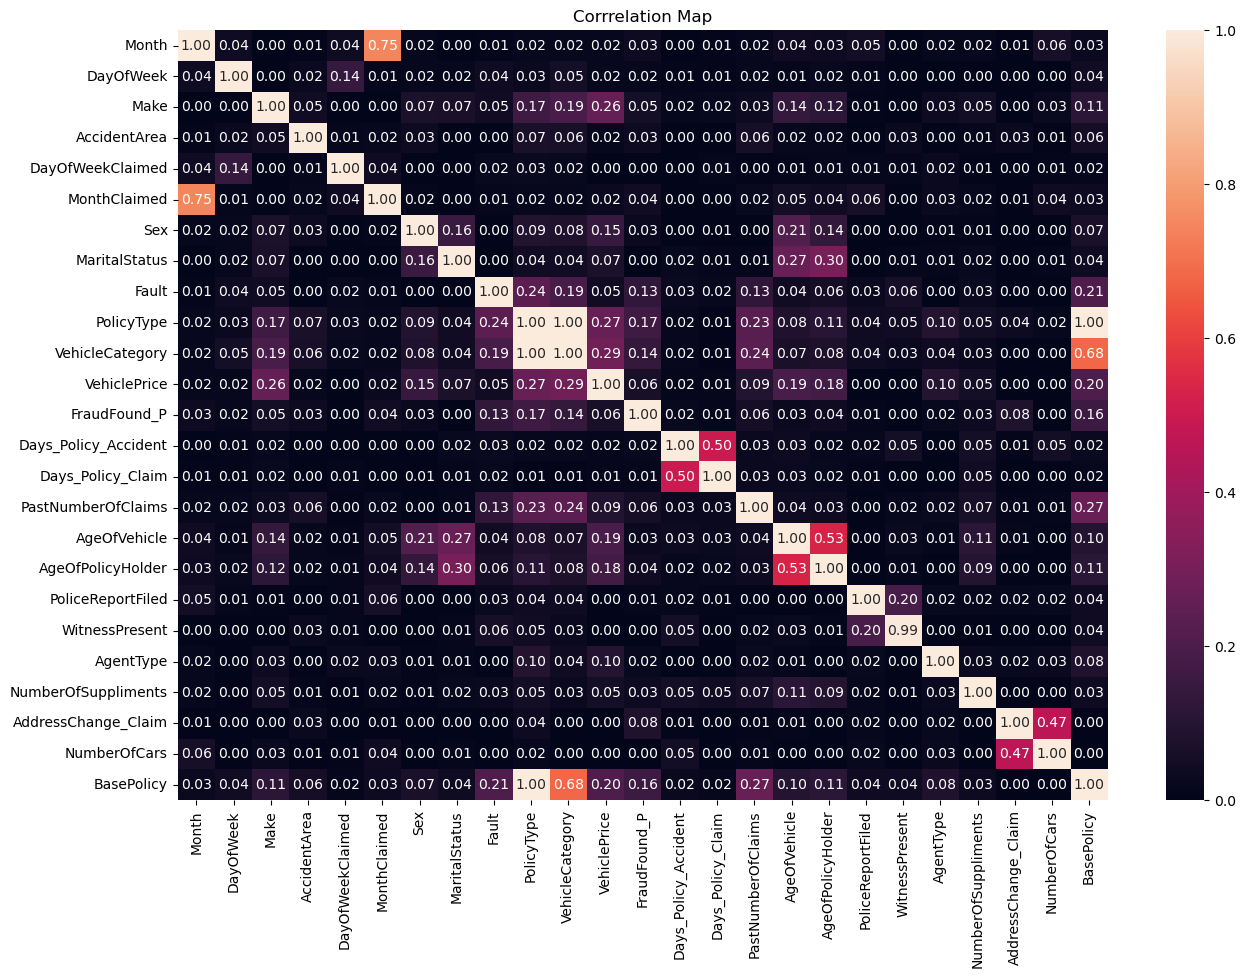

In [20]:
# Correlation Between Categorial & Target
ob=[]
for data in df.columns:
    if data == 'FraudFound_P':
        ob.append(data)
    if df[data].dtype=='object':
        ob.append(data)
        
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

cramers_df = pd.DataFrame(index=ob)

for x in ob:
    a = []
    for y in ob:
        a.append(cramers_v(df[y], df[x]))
    cramers_df[x] = a


plt.figure(figsize=(15,10))
sns.heatmap(cramers_df, annot=True, fmt='.2f')
plt.title('Corrrelation Map')
plt.show()


# Preprocessing

In [21]:
# Drop Policy Type
df = df.drop(columns='PolicyType')

## Encode Categorical Data

In [22]:
#preparing a base table for encoding to convert categorical to numerical
col_ordering = [
    {'col':'AccidentArea','mapping':{'Urban':1, 'Rural':0}},
    {'col':'Sex','mapping':{'Female':1, 'Male':0}},
    {'col':'Fault','mapping':{'Policy Holder':1, 'Third Party':0}},
    {'col':'PoliceReportFiled','mapping':{'Yes':1, 'No':0}},
    {'col':'WitnessPresent','mapping':{'Yes':1, 'No':0}},
    {'col':'AgentType','mapping':{'External':1, 'Internal':0}},
    {'col':'Month','mapping':{'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}},
    {'col':'DayOfWeek','mapping':{'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}},
    {'col':'DayOfWeekClaimed','mapping':{'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}},
    {'col':'MonthClaimed','mapping':{'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}},
    {'col':'PastNumberOfClaims','mapping':{'none':0 ,'1':1,'2 to 4':2,'more than 4':3 }},
    {'col':'NumberOfSuppliments','mapping':{'none':0,'1 to 2':1,'3 to 5':2,'more than 5':3}}, 
    {'col':'VehiclePrice','mapping':{'less than 20000':0,'20000 to 29000':1,'30000 to 39000':2,
                                     '40000 to 59000':3,'60000 to 69000':4,'more than 69000':5}},
    {'col':'AgeOfVehicle','mapping':{'3 years':3,'6 years':6,'7 years':7,'more than 7':8,'5 years':5,'new':0,'4 years':4,'2 years':2}},
    {'col':'Days_Policy_Accident','mapping':{'more than 30':4,'15 to 30':3,'none':0,'1 to 7':1,'8 to 15':2}},
    {'col':'Days_Policy_Claim','mapping':{'more than 30':4,'15 to 30':3,'none':0,'1 to 7':1,'8 to 15':2}},
    {'col':'AgeOfPolicyHolder','mapping':{'16 to 17':1,'18 to 20':2,'21 to 25':3,'26 to 30':4,'31 to 35':5,'36 to 40':6,
                                          '41 to 50':7,'51 to 65':8,'over 65':9}},
    {'col':'AddressChange_Claim','mapping':{'no change':0,'under 6 months':1,'1 year':2,'2 to 3 years':3,'4 to 8 years':4}},
    {'col':'NumberOfCars','mapping':{'1 vehicle':1,'2 vehicles':2,'3 to 4':3,'5 to 8':4,'more than 8':5}}
]
ord_encoder = OrdinalEncoder(mapping = col_ordering, return_df=True)

In [23]:
df2 = ord_encoder.fit_transform(df)

In [24]:
#reated one hot encoding for below variables
OHE = OneHotEncoder(cols = ['Make','MaritalStatus','VehicleCategory','BasePolicy'],use_cat_names=True, return_df=True) 
df3 = OHE.fit_transform(df2)

In [25]:
df3.shape

(15419, 56)

# 5.  Split Data

In [26]:
X = df3.drop(columns='FraudFound_P') #independent #input
y = df3['FraudFound_P'] #dependent #output

In [27]:
#train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)

In [28]:
y_train.value_counts()

0    11623
1      712
Name: FraudFound_P, dtype: int64

In [29]:
y_test.value_counts()

0    2873
1     211
Name: FraudFound_P, dtype: int64

# Over Sampling

In [30]:
#as we found that the data is imbalanced, we try to over sample the data to avoid bias
oversample = SMOTE(sampling_strategy=0.5)
X_over, y_over = oversample.fit_resample(X_train, y_train)
print('After Oversampling:\n',y_over.value_counts())

After Oversampling:
 0    11623
1     5811
Name: FraudFound_P, dtype: int64


In [31]:
X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(X_over, y_over, test_size=0.2, random_state=48)

# Under sampling

In [32]:
#under sampling the data
join_train = pd.concat([X_train, y_train], axis=1)
claim = join_train[join_train['FraudFound_P']==1]
no_claim = join_train[join_train['FraudFound_P']==0]

undersample_noclaim = no_claim.sample(len(claim)*2)
join_train2 = pd.concat([claim,undersample_noclaim])

print("Before Undersample:\n", join_train['FraudFound_P'].value_counts())
print("After Undersample:\n", join_train2['FraudFound_P'].value_counts())

X_under = join_train2.drop(columns='FraudFound_P')
y_under = join_train2['FraudFound_P']

Before Undersample:
 0    11623
1      712
Name: FraudFound_P, dtype: int64
After Undersample:
 0    1424
1     712
Name: FraudFound_P, dtype: int64


In [33]:
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under, y_under, test_size=0.2, random_state=48)

In [34]:
#from sklearn.model_selection import cross_val_score
LR = LogisticRegression()
cv_normal = cross_val_score(LR, X, y, cv=5)
cv_over = cross_val_score(LR, X_over, y_over, cv=5)
cv_under = cross_val_score(LR, X_under, y_under, cv=5)

Accuracy on normal data [94.034 94.001 94.001 93.969 94.032]
Accuracy on over sample data [73.014 80.929 80.987 82.592 79.289]
Accuracy on under sample data [70.561 66.979 72.365 68.618 72.131]


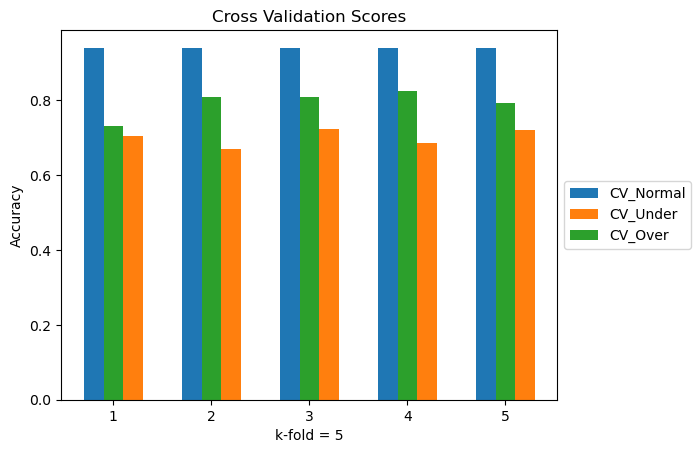

In [35]:
#checking the cross validation scores
print("Accuracy on normal data",np.round(cv_normal*100,3 ))
print("Accuracy on over sample data",np.round(cv_over*100,3 ))
print("Accuracy on under sample data",np.round(cv_under*100,3 ))

X = ['1','2','3','4','5']

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2,cv_normal , 0.2, label = 'CV_Normal')
plt.bar(X_axis + 0.2, cv_under, 0.2, label = 'CV_Under')
plt.bar(X_axis , cv_over, 0.2, label = 'CV_Over')
plt.xticks(X_axis, X)
plt.xlabel("k-fold = 5")
plt.ylabel("Accuracy")
plt.title("Cross Validation Scores")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# 6. Model Function

In [36]:
#Algorithms we used to train the model
LR = LogisticRegression()
svm = SVC()
NB = GaussianNB()
DT = DecisionTreeClassifier()
RF = RandomForestClassifier()
NN = MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32, 16, 8), 
                   max_iter=300,
                   activation = 'relu',
                   solver='adam',
                   random_state=1)

In [37]:
#training each model with normal data, over sampled data and under sampled data
#Accuracy = TP+TN/Tp+TN+FP+FN
#Precision = TP/TP+FP
#Recall = TP/TP+FN

LR_normal = LR.fit(X_train, y_train)
LR_y_normal_pred = LR_normal.predict(X_test)
LR_Acc_normal = accuracy_score(LR_y_normal_pred, y_test)*100
LR_Rec_normal = recall_score(LR_y_normal_pred, y_test)*100
LR_Pre_normal = precision_score(LR_y_normal_pred, y_test)*100

LR_over = LR.fit(X_over_train, y_over_train)
LR_y_over_pred = LR_over.predict(X_over_test)
LR_Acc_over = accuracy_score(LR_y_over_pred, y_over_test)*100
LR_Rec_over = recall_score(LR_y_over_pred, y_over_test)*100
LR_Pre_over = precision_score(LR_y_over_pred, y_over_test)*100

LR_under = LR.fit(X_under_train, y_under_train)
LR_y_under_pred = LR_under.predict(X_under_test)
LR_Acc_under = accuracy_score(LR_y_under_pred, y_under_test)*100
LR_Rec_under = recall_score(LR_y_under_pred, y_under_test)*100
LR_Pre_under = precision_score(LR_y_under_pred, y_under_test)*100

In [38]:
svm_normal = svm.fit(X_train, y_train)
svm_y_normal_pred = svm_normal.predict(X_test)
svm_Acc_normal = accuracy_score(svm_y_normal_pred, y_test)*100
svm_Rec_normal = recall_score(svm_y_normal_pred, y_test)*100
svm_Pre_normal = precision_score(svm_y_normal_pred, y_test)*100

svm_over = svm.fit(X_over_train, y_over_train)
svm_y_over_pred = svm_over.predict(X_test)
svm_Acc_over = accuracy_score(svm_y_over_pred, y_test)*100
svm_Rec_over = recall_score(svm_y_over_pred, y_test)*100
svm_Pre_over = precision_score(svm_y_over_pred, y_test)*100

svm_under = svm.fit(X_under_train, y_under_train)
svm_y_under_pred = svm_under.predict(X_test)
svm_Acc_under = accuracy_score(svm_y_under_pred, y_test)*100
svm_Rec_under = recall_score(svm_y_under_pred, y_test)*100
svm_Pre_under = precision_score(svm_y_under_pred, y_test)*100

In [39]:
NB_normal = NB.fit(X_train, y_train)
NB_y_normal_pred = NB_normal.predict(X_test)
NB_Acc_normal = accuracy_score(NB_y_normal_pred, y_test)*100
NB_Rec_normal = recall_score(NB_y_normal_pred, y_test)*100
NB_Pre_normal = precision_score(NB_y_normal_pred, y_test)*100

NB_over = NB.fit(X_over_train, y_over_train)
NB_y_over_pred = NB_over.predict(X_test)
NB_Acc_over = accuracy_score(NB_y_over_pred, y_test)*100
NB_Rec_over = recall_score(NB_y_over_pred, y_test)*100
NB_Pre_over = precision_score(NB_y_over_pred, y_test)*100

NB_under = NB.fit(X_under_train, y_under_train)
NB_y_under_pred = NB_under.predict(X_test)
NB_Acc_under = accuracy_score(NB_y_under_pred, y_test)*100
NB_Rec_under = recall_score(NB_y_under_pred, y_test)*100
NB_Pre_under = precision_score(NB_y_under_pred, y_test)*100

In [40]:
DT_normal = DT.fit(X_train, y_train)
DT_y_normal_pred = DT_normal.predict(X_test)
DT_Acc_normal = accuracy_score(DT_y_normal_pred, y_test)*100
DT_Rec_normal = recall_score(DT_y_normal_pred, y_test)*100
DT_Pre_normal = precision_score(DT_y_normal_pred, y_test)*100

DT_over = DT.fit(X_over_train, y_over_train)
DT_y_over_pred = DT_over.predict(X_test)
DT_Acc_over = accuracy_score(DT_y_over_pred, y_test)*100
DT_Rec_over = recall_score(DT_y_over_pred, y_test)*100
DT_Pre_over = precision_score(DT_y_over_pred, y_test)*100

DT_under = DT.fit(X_under_train, y_under_train)
DT_y_under_pred = DT_under.predict(X_test)
DT_Acc_under = accuracy_score(DT_y_under_pred, y_test)*100
DT_Rec_under = recall_score(DT_y_under_pred, y_test)*100
DT_Pre_under = precision_score(DT_y_under_pred, y_test)*100

In [41]:
RF_normal = RF.fit(X_train, y_train)
RF_y_normal_pred = RF_normal.predict(X_test)
RF_Acc_normal = accuracy_score(RF_y_normal_pred, y_test)*100
RF_Rec_normal = recall_score(RF_y_normal_pred, y_test)*100
RF_Pre_normal = precision_score(RF_y_normal_pred, y_test)*100

RF_over = RF.fit(X_over_train, y_over_train)
y_over_pred = RF_over.predict(X_test)
RF_Acc_over = accuracy_score(y_over_pred, y_test)*100
RF_Rec_over = recall_score(y_over_pred, y_test)*100
RF_Pre_over = precision_score(y_over_pred, y_test)*100

RF_under = RF.fit(X_under_train, y_under_train)
RF_y_under_pred = RF_under.predict(X_test)
RF_Acc_under = accuracy_score(RF_y_under_pred, y_test)*100
RF_Rec_under = recall_score(RF_y_under_pred, y_test)*100
RF_Pre_under = precision_score(RF_y_under_pred, y_test)*100

In [42]:
NN_normal = NN.fit(X_train, y_train)
NN_y_normal_pred = NN_normal.predict(X_test)
NN_Acc_normal = accuracy_score(NN_y_normal_pred, y_test)*100
NN_Rec_normal = recall_score(NN_y_normal_pred, y_test)*100
NN_Pre_normal = precision_score(NN_y_normal_pred, y_test)*100

NN_over = NN.fit(X_over_train, y_over_train)
NN_y_over_pred = NN_over.predict(X_test)
NN_Acc_over = accuracy_score(NN_y_over_pred, y_test)*100
NN_Rec_over = recall_score(NN_y_over_pred, y_test)*100
NN_Pre_over = precision_score(NN_y_over_pred, y_test)*100

NN_under = NN.fit(X_under_train, y_under_train)
NN_y_under_pred = NN_under.predict(X_test)
NN_Acc_under = accuracy_score(NN_y_under_pred, y_test)*100
NN_Rec_under = recall_score(NN_y_under_pred, y_test)*100
NN_Pre_under = precision_score(NN_y_under_pred, y_test)*100

# Results

In [43]:
#creating the dataframe for accuray, Recall and precision scores
data = {'Classifiers': ['LogisticRegression_Normal','SVM_Normal','GaussianNB_Normal','DecisionTreeClassifier_Normal' ,'RandomForestClassifier_Normal' ,'MLPClassifier_Normal',
                        'LogisticRegression_Over','SVM_Over','GaussianNB_Over','DecisionTreeClassifier_Over' ,'RandomForestClassifier_Over' ,'MLPClassifier_Over' ,
                        'LogisticRegression_Under','SVM_Under','GaussianNB_Under','DecisionTreeClassifier_Under' ,'RandomForestClassifier_Under' ,'MLPClassifier_Under'],
        
               'Accuracy': [LR_Acc_normal, svm_Acc_normal, NB_Acc_normal,DT_Acc_normal,RF_Acc_normal,NN_Acc_normal,
                            LR_Acc_over, svm_Acc_over,NB_Acc_over,DT_Acc_over,RF_Acc_over,NN_Acc_over,
                            LR_Acc_under,svm_Acc_under,NB_Acc_under,DT_Acc_under,RF_Acc_under,NN_Acc_under],
        
                'Recall': [LR_Rec_normal, svm_Rec_normal, NB_Rec_normal,DT_Rec_normal,RF_Rec_normal,NN_Rec_normal,
                           LR_Rec_over, svm_Rec_over,NB_Rec_over,DT_Rec_over,RF_Rec_over,NN_Rec_over,
                           LR_Rec_under,svm_Rec_under,NB_Rec_under,DT_Rec_under,RF_Rec_under,NN_Rec_under],
        
                'Preision': [LR_Pre_normal, svm_Pre_normal, NB_Pre_normal,DT_Pre_normal,RF_Pre_normal,NN_Pre_normal,
                             LR_Pre_over, svm_Pre_over,NB_Pre_over,DT_Pre_over,RF_Pre_over,NN_Pre_over,
                             LR_Pre_under,svm_Pre_under,NB_Pre_under,DT_Pre_under,RF_Pre_under,NN_Pre_under]
       }
Accuracies = pd.DataFrame(data=data)
Accuracies.set_index('Classifiers', inplace=True)
Accuracies

,Accuracy,Recall,Preision
Classifiers,,,
LogisticRegression_Normal,93.158236,0.000000,0.000000
SVM_Normal,93.158236,0.000000,0.000000
GaussianNB_Normal,59.630350,13.124108,87.203791
DecisionTreeClassifier_Normal,89.721141,21.808511,19.431280
RandomForestClassifier_Normal,93.158236,0.000000,0.000000
MLPClassifier_Normal,93.158236,0.000000,0.000000
LogisticRegression_Over,83.854316,79.047619,70.758738
SVM_Over,93.158236,0.000000,0.000000
GaussianNB_Over,50.843061,9.697344,74.407583


In [44]:
print(y_over_test.shape)
print(LR_y_over_pred.shape)

(3487,)
(3487,)


In [45]:
label=['negative','positive' ]

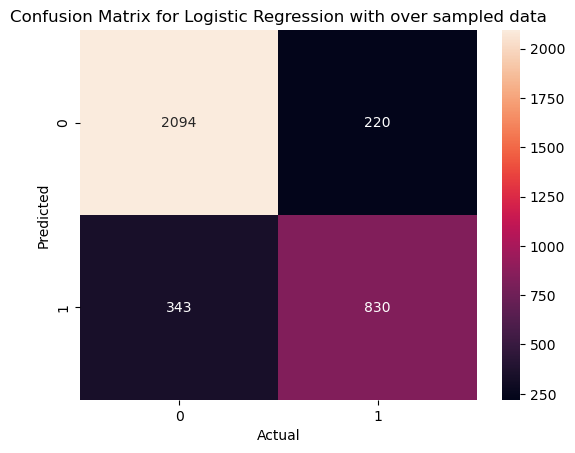

In [46]:
cm=confusion_matrix(y_over_test, LR_y_over_pred)
sns.heatmap(cm, annot=True, fmt='g')  #annot=True to annotate cells, ftm='g' to disable scientific notation
plt.title("Confusion Matrix for Logistic Regression with over sampled data")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

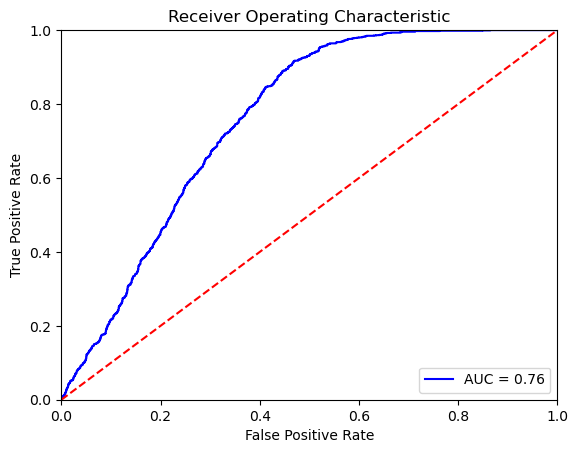

In [48]:
probs = LR_over.predict_proba(X_over_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_over_test, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Thank You

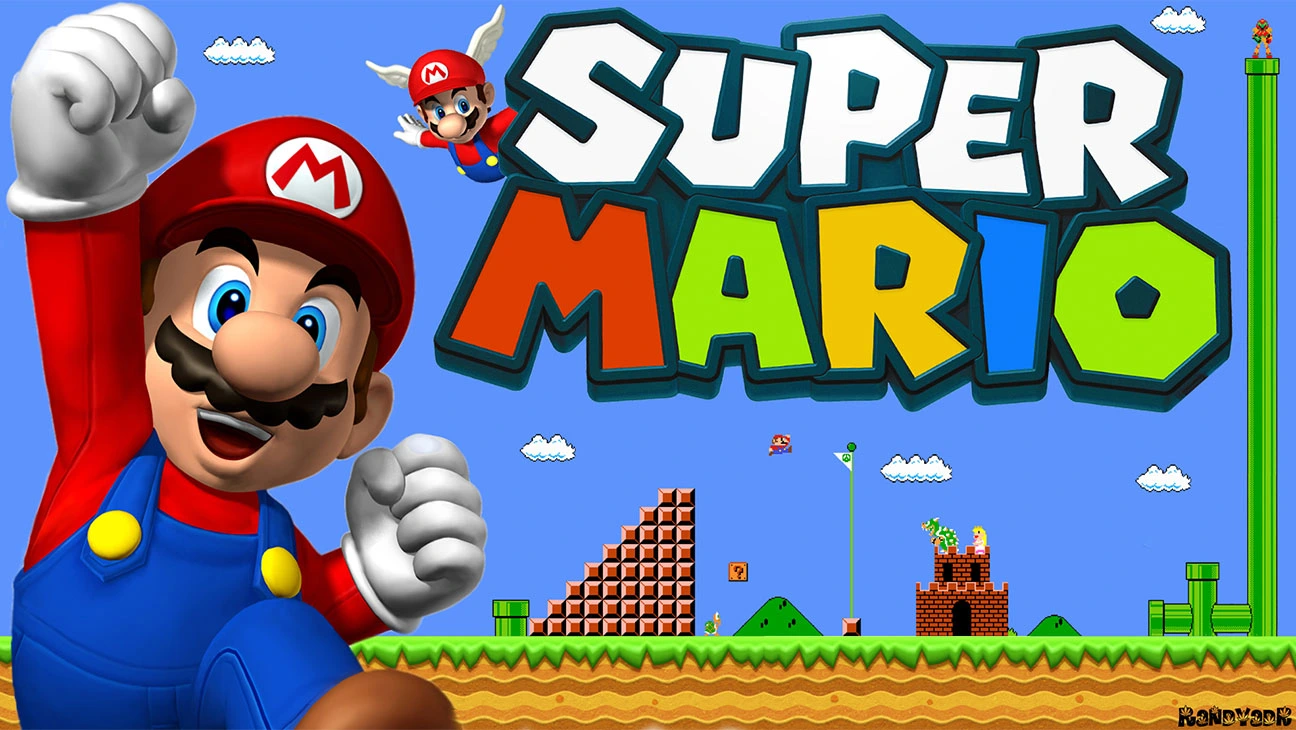